In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
descriptive_prompt_9 =  "Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Tell me how many residues are in the chains and beta sheets. 3. Find any known binding or active sites. 4. Simulate for 1 ps at 300 K. 5. Compute the RMSD of the simulation at 300 K. 6. Compute the radius of gyration over time for the simulation at 300 K. 7. Simulate for 1 ps at 400 K. 8. Compute the RMSD of the simulation at 400 K. 9. Compute the radius of gyration over time for the simulation at 400 K."
non_descriptive_prompt_9 = "Simulate 1LYZ for 1 ps at 300K and 400K. Tell me how many residues are in the chains and beta sheets and any known binding or active sites. Compute RMSD and radius of gyration of both simulations."

Required Tasks:
- Download
- SS Analysis
- Simulation_1
- RMSD_1
- Rgy_1
- Simulation_2
- RMSD_2
- Rgy_2
- Binding/Active Sites

In [3]:
llm_model = "claude-3-opus-20240229"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_1.run(descriptive_prompt_9)

Thought: To complete the tasks, I will need to download the PDB file for 1LYZ, analyze its structure, find binding and active sites, run simulations at different temperatures, and compute RMSD and radius of gyration for each simulation. I will start by downloading the PDB file.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file downloaded, I can analyze the structure to determine the number of residues in the chains and beta sheets using the GetTurnsBetaSheetsHelices tool.

Action:
```
{
  "action": "GetTurnsBetaSheetsHelices",
  "action_input": {
    "query": "1LYZ",
    "primary_accession": "P00720"
  }
}
```

The primary accession number provided does not match any entry in the data, using the first entry instead.
The primary accession number provided does not match any entry in the data, using the first entry instead.
The primary accession number provided does not match any entry in

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [5]:
registry = agent_1.path_registry
print(registry.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_233542: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_233542
 1LYZ_233637: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_233646: Initial positions for simulation sim0_233646
 sim0_233646: Basic Simulation of Protein 1LYZ_233637
 rec0_233646: Simulation trajectory for protein 1LYZ_233637 and simulation sim0_233646
 rec1_233646: Simulation state log for protein 1LYZ_233637 and simulation sim0_233646
 rec2_233646: Simulation pdb frames for protein 1LYZ_233637 and simulation sim0_233646
 rmsd_1LYZ: RMSD for 1LYZ
 fig0_233733: RMSD plot for 1LYZ
 rgy_rec0_233646: Radii of gyration per frame for rec0_233646


In [7]:
traj_path = registry.get_mapped_path("rec0_233646")
top_path = registry.get_mapped_path("top_sim0_233646")

assert os.path.exists(registry.get_mapped_path('1LYZ_233542'))
assert os.path.exists(traj_path)
assert os.path.exists(top_path)
assert os.path.exists(registry.get_mapped_path('rmsd_1LYZ'))
assert os.path.exists(registry.get_mapped_path('rgy_rec0_233646'))

In [8]:
traj = md.load(traj_path, top=top_path)
traj = traj[-1]
#get dssp 
number_of_chains = traj.n_chains
secondary_structure = md.compute_dssp(traj,simplified=True)
print("Number of chains: ",number_of_chains)
print("Number of sheets: ",len([i for i in secondary_structure[0] if i == 'E']))
print("Number of helices: ",len([i for i in secondary_structure[0] if i == 'H']))
print("Number of coils: ",len([i for i in secondary_structure[0] if i == 'C']))

Number of chains:  1
Number of sheets:  10
Number of helices:  42
Number of coils:  77


In [12]:
from mdagent.tools.base_tools import SummarizeProteinStructure
print (SummarizeProteinStructure(registry).run('1LYZ_233542'))

{'n_atoms': 1102, 'n_residues': 230, 'n_chains': 2, 'n_frames': 1, 'n_bonds': 1025}


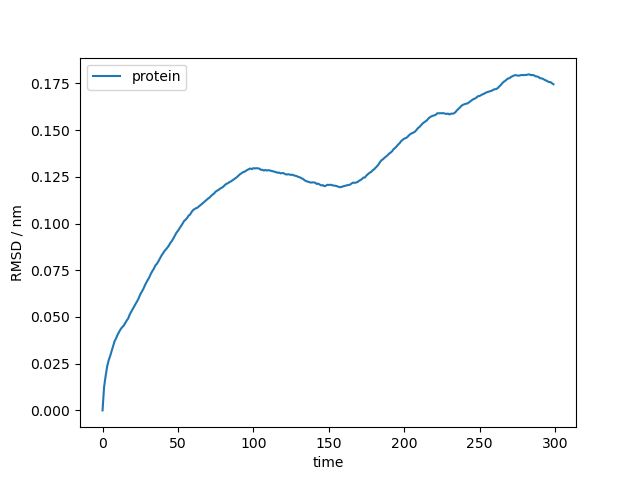

In [13]:
#plot rmsd
from IPython.display import Image
Image(filename=registry.get_mapped_path('fig0_233733'))

In [14]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_2.run(non_descriptive_prompt_9)

Thought: To simulate 1LYZ at 300K and 400K for 1 ps each, I will first need to download the PDB file. Then I can set up and run the simulations using the SetUpandRunFunction tool. After the simulations are complete, I can analyze the trajectories to get the requested information.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Here are the next steps to continue simulating 1LYZ and analyzing the results:

Thought: Now that I have the 1LYZ PDB file, I can set up and run a 1 ps simulation at 300K using the SetUpandRunFunction tool. I'll modify the default parameters to run for 1 ps (500,000 steps) and save the trajectory.

Action:
```
{
  "action": "SetUpandRunFunction",
  "action_input": {
    "pdb_id": "1LYZ_234630",
    "forcefield_files": ["amber14/protein.ff14SB.xml", "amber14/tip3p.xml"],
    "save": true,
    "system_params": {
      "nonbondedMethod": "PME", 
      "nonbondedCutoff": 1.0,
      "constraints": "HBon

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [16]:
registry = agent_2.path_registry
print(registry.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_234630: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_234630
 1LYZ_234700: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_234716: Initial positions for simulation sim0_234716
 sim0_234716: Basic Simulation of Protein 1LYZ_234700
 rec0_234722: Simulation trajectory for protein 1LYZ_234700 and simulation sim0_234716
 rec1_234722: Simulation state log for protein 1LYZ_234700 and simulation sim0_234716
 rec2_234722: Simulation pdb frames for protein 1LYZ_234700 and simulation sim0_234716
 top_sim0_061956: Initial positions for simulation sim0_061956
 sim0_061956: Basic Simulation of Protein 1LYZ_234700
 rec0_062002: Simulation trajectory for protein 1LYZ_234700 and simulation sim0_061956
 rec1_062002: Simulation state log for protein 1LYZ_234700 and simulation sim0_061956
 rec2_062002: Simulation pdb frames for protein 1LYZ_2347

In [17]:
traj_path = registry.get_mapped_path("rec0_234722")
top_path = registry.get_mapped_path("top_sim0_234716")

assert os.path.exists(registry.get_mapped_path('1LYZ_234700'))
assert os.path.exists(traj_path)
assert os.path.exists(top_path)
# assert os.path.exists(registry.get_mapped_path('rmsd_path'))
# assert os.path.exists(registry.get_mapped_path('rgy_path'))

In [21]:
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry)
dssp._run(traj_file="rec0_234722", top_file="top_sim0_234716", target_frames="all")

"{'residues in helix': 5379, 'residues in strand': 1374, 'residues in coil': 6147, 'residues not assigned, not a protein residue': 678800}"

In [22]:
traj = md.load(traj_path, top=top_path)
traj = traj[-1]
#get dssp 
number_of_chains = traj.n_chains
secondary_structure = md.compute_dssp(traj,simplified=True)
print("Number of chains: ",number_of_chains)
print("Number of sheets: ",len([i for i in secondary_structure[0] if i == 'E']))
print("Number of helices: ",len([i for i in secondary_structure[0] if i == 'H']))
print("Number of coils: ",len([i for i in secondary_structure[0] if i == 'C']))

Number of chains:  3
Number of sheets:  14
Number of helices:  51
Number of coils:  64


In [25]:
SummarizeProteinStructure(registry).run('1LYZ_234700')

"{'n_atoms': 1960, 'n_residues': 129, 'n_chains': 1, 'n_frames': 1, 'n_bonds': 1984}"